### Load Library

In [1]:
import os, warnings, sklearn, matplotlib, torch, time, cv2, math, sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
#from keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.layers import Concatenate
from matplotlib import pyplot
import tensorflow.keras as K
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

In [4]:
# GPU-initialization
session = None
if (session):
    session.close()
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs: 0


---

### Load Tensor

In [8]:
def load_tensor(dir_path = [".", "output", "tensor"]):
    '''
    tensor 가져오는 방식을 csv에서 가져온 번호에서 부터 불러오도록 설정
    output 에 nums는 현재 가져온곳의 한글값을 표현하기 위해서 
    '''
    dir_path = os.path.join(*dir_path)
    tensor_folders = sorted(os.listdir(dir_path))
    
    h_list = []
    answers = []
    
    # 0 ~ 7 순회
    for tensor_folder in tensor_folders:
        if tensor_folder == "prediction":
            continue
            
        if tensor_folder == "temp":
            continue
        
        if tensor_folder == "숫자":
            continue
                
        tensors_path = os.path.join(dir_path + "\\" + tensor_folder)
        tensors = sorted(os.listdir(tensors_path))
        
        
        # 각각의 숫자 순회
        for tensor in tensors:                
            h_list.append(torch.load(tensors_path + "\\" + tensor + "\\hand.pt"))
            #h_list.append(torch.load(tensors_path + "\\" + tensor + "\\hp.pt"))
            answers.append(tensor_folder)
            

    return h_list, answers

In [9]:
h_list, answers = load_tensor() # 훈련데이터
answer_set = list(map(str, sorted(list(set(answers))))) # 정답데이터

In [10]:
# 시퀀스 최대 길이 설정(각 영상의 최대 프레임 추출 후 이를 적용)
def matchFrame(lst, max_frame):
    for i in range(len(lst)):
        lst[i] = lst[i].view(lst[i].shape[0], -1)
        lst[i] = np.array(F.pad(lst[i], (0, 0, 0, max_frame - lst[i].shape[0]), value=0))
    return np.array(lst)

In [11]:
# 시퀀스 최대 길이 출력
mx = 0
for i in h_list:
       mx = max(mx, i.shape[0])
print(mx)

129


In [12]:
# 시퀀스 최대길이 설정
hand_data = matchFrame(h_list, mx)

In [13]:
# 훈련데이터 Shape
print(hand_data[0].shape)

(129, 126)


In [14]:
x_train, x_val, y_train, y_val = train_test_split(hand_data, answers, test_size=0.075, random_state=42)
#x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [15]:
print(answer_set)

['0', '1', '2', '3', '4', '5', '6', '7', '가끔', '가렵다', '가슴', '감기', '고열', '골절', '교통사고', '구내염', '귀', '근육통', '눈', '다리', '두드러기', '두통', '등', '목', '몸', '몸살', '무릎', '물다', '발목', '부러지다', '붕대', '뼈', '사마귀', '설사', '소화불량', '손', '수술', '심장마비', '쓰러지다', '아프다', '안녕하세요', '어깨', '어지럽다', '얼굴', '열', '의사', '임신', '자주', '찰과상', '코로나', '탈구', '토하다', '파상풍', '피', '피부', '허리', '호흡곤란', '화상']


In [16]:
x_train.shape

(5326, 129, 126)

In [17]:
# 정답 데이터 원핫인코딩
encoder = LabelBinarizer()
test = encoder.fit_transform(answer_set)

y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
#y_test = encoder.transform(y_test)

In [18]:
# 정답 데이터 shape
print(y_train.shape)

(5326, 58)


### Training

In [19]:
# 바다나우 어텐션
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
# ResNet Unit
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv1D(filters, 3, strides=strides,
            					padding="same", activation = "relu",use_bias=False),
            keras.layers.BatchNormalization(),
            #self.activation,
            keras.layers.Conv1D(filters, 3, strides=1,
            					padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv1D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [21]:
# Model
dropout = 0.25
num_classes = len(answer_set)
nodesizes = [64, 64]

inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))

conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation("relu")(conv1)
conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

conv1 = ResidualUnit(32, 1)(conv1)
conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

conv1 = ResidualUnit(64, 2)(conv1)
conv1 = keras.layers.MaxPool1D(pool_size=3, strides=2)(conv1)

lstm = Bidirectional(layers.LSTM(128, return_sequences=True))(conv1)
lstm = layers.Dropout(rate=dropout)(lstm)  

for i in range(0,2):    #number of layers random between 1 an 3
    lstm = Bidirectional(layers.LSTM(nodesizes[i],return_sequences=True))(lstm)
    lstm = layers.Dropout(rate=dropout)(lstm)

#lstm = Bidirectional(layers.LSTM(256))(lstm)
#lstm = layers.Dropout(rate=dropout)(lstm)

lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (layers.LSTM(64, return_sequences=True, return_state=True))(lstm)

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) # 가중치 크기 정의

context_vector, attention_weights = attention(lstm, state_h)
dense1 = Dense(64, activation="relu")(context_vector)
dropout = layers.Dropout(0.)(dense1)

class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(dense1)

model = keras.models.Model(inputs=inputs, outputs=[class_output])
# Plot the model graph
keras.utils.plot_model(model, 'nn_graph.png', show_shapes=True)

model.compile(loss={
    'class_output': 'categorical_crossentropy', 
    },
    optimizer='Adamax',
    metrics=['accuracy'])

model.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 126)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 129, 32)      12128       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 129, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None,

In [22]:
epc = 60

history = model.fit(
    x_train, y_train, 
    epochs=epc, 
    batch_size=30, 
    validation_data=(x_val,y_val),
    shuffle=False)

Epoch 1/60
178/178 [==============================] - 8s 43ms/step - loss: 3.3958 - accuracy: 0.1160 - val_loss: 3.3721 - val_accuracy: 0.1296
Epoch 2/60
178/178 [==============================] - 6s 31ms/step - loss: 2.0013 - accuracy: 0.4149 - val_loss: 1.9367 - val_accuracy: 0.4352
Epoch 3/60
178/178 [==============================] - 6s 31ms/step - loss: 1.3894 - accuracy: 0.6025 - val_loss: 1.2433 - val_accuracy: 0.6181
Epoch 4/60
178/178 [==============================] - 6s 31ms/step - loss: 0.9801 - accuracy: 0.7197 - val_loss: 0.8957 - val_accuracy: 0.7037
Epoch 5/60
178/178 [==============================] - 6s 31ms/step - loss: 0.6916 - accuracy: 0.7991 - val_loss: 0.8155 - val_accuracy: 0.7176
Epoch 6/60
178/178 [==============================] - 6s 31ms/step - loss: 0.5108 - accuracy: 0.8549 - val_loss: 0.4580 - val_accuracy: 0.8403
Epoch 7/60
178/178 [==============================] - 6s 31ms/step - loss: 0.3809 - accuracy: 0.8920 - val_loss: 0.4309 - val_accuracy: 0.8727

Epoch 58/60
178/178 [==============================] - 5s 31ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0602 - val_accuracy: 0.9838
Epoch 59/60
178/178 [==============================] - 6s 31ms/step - loss: 0.0117 - accuracy: 0.9974 - val_loss: 0.1241 - val_accuracy: 0.9653
Epoch 60/60
178/178 [==============================] - 6s 31ms/step - loss: 0.0212 - accuracy: 0.9949 - val_loss: 0.1440 - val_accuracy: 0.9653


---

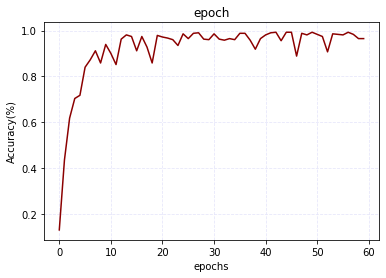

<Figure size 432x288 with 0 Axes>

In [23]:
# 도화지 생성
fig = plt.figure()
# 정확도 그래프 그리기
plt.plot(range(epc), history.history['val_accuracy'], label='Accuracy', color='darkred')
# 축 이름
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
plt.title('epoch')
plt.grid(linestyle='--', color='lavender')
# 그래프 표시
plt.show()
# 그래프 저장
plt.savefig('sign_launguage_acc.png')

---
### Prediction

In [24]:
def load_predData(path = ['.', 'output', 'tensor', 'prediction']):
    prec = []
    answer = []
    
    pred_datas_path = os.path.join(*path)
    pred_datas = sorted(os.listdir(pred_datas_path))

    for pred_data in pred_datas:
        
        if pred_data == "temp":
            continue
        pred_data_path = pred_datas_path + "\\" + pred_data
        
        for data in os.listdir(pred_data_path):
            if data == "hp.pt":
                continue
            prec.append(torch.load(pred_data_path + "\\" + data))
            answer.append(pred_data)
            
    return prec, answer

In [25]:
prec, answer = load_predData()

In [26]:
print(answer)

['0', '1', '2', '3', '4', '5', '6', '7', '가끔', '가렵다', '가슴', '감기', '고열', '골절', '교통사고', '구내염', '귀', '근육통', '눈', '다리', '두드러기', '두통', '등', '목', '몸', '몸살', '무릎', '물다', '발목', '부러지다', '붕대', '뼈', '사마귀', '설사', '소화불량', '손', '수술', '심장마비', '쓰러지다', '아프다', '안녕하세요', '어깨', '어지럽다', '얼굴', '열', '의사', '임신', '자주', '찰과상', '코로나', '탈구', '토하다', '파상풍', '피', '피부', '허리', '호흡곤란', '화상']


In [27]:
prec = matchFrame(prec, mx)

In [28]:
prec.shape

(58, 129, 126)

In [29]:
prec[0].shape

(129, 126)

In [30]:
def percentage(pred, answer):
    u = 0
    d = 0
    
    for p, a in zip(pred, answer):
        if p == a:
            u += 1
            d += 1
            
        else:
            d += 1
            
    return str(u / d) + "%"

def Correct(a, b):
    return True if a == b else False

In [31]:
prediction = []
print("틀린 단어")
print('--------------------------------------------------------')
cnt = 0
for prd, ans in zip(model.predict(prec), answer):
    prediction.append(answer_set[np.argmax(prd)])
    if not Correct(ans, answer_set[np.argmax(prd)]):
        cnt += 1
        print("answer :", ans, ", predction :" ,answer_set[np.argmax(prd)])

print('--------------------------------------------------------')
print("전체 개수 :", len(prediction), "      틀린 개수 :", cnt)

틀린 단어
--------------------------------------------------------
answer : 0 , predction : 3
answer : 5 , predction : 2
answer : 6 , predction : 7
answer : 가끔 , predction : 4
answer : 가슴 , predction : 교통사고
answer : 감기 , predction : 호흡곤란
answer : 귀 , predction : 0
answer : 두통 , predction : 가끔
answer : 몸살 , predction : 붕대
answer : 뼈 , predction : 탈구
answer : 수술 , predction : 임신
answer : 어깨 , predction : 심장마비
answer : 어지럽다 , predction : 등
answer : 피부 , predction : 가렵다
--------------------------------------------------------
전체 개수 : 58       틀린 개수 : 14


In [32]:
print("정답률 =", percentage(prediction, answer))

정답률 = 0.7586206896551724%
